In [1]:
import hydra
import torch
from src.commons.constants import PROJECT_PATH
from omegaconf import DictConfig, OmegaConf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def load_config():
    # Initialize the Hydra configuration
    hydra.initialize(config_path="../configs", version_base=None)
    
    # Compose the configuration with the desired environment override
    cfg = hydra.compose(
        config_name="train", 
        overrides=["experiment=adapter_concat", 
                   "sam_type=small", 
                   "data=levir-cd",
                   "data.params.batch_size=1"
                  ])
    
    return cfg

def get_dloader(mode: str, dmodule):

    def wrap_mode(mode):
        if mode == "train":
            return "fit"
        return mode
    if not dmodule.ds_dict_type:
        mode_ = wrap_mode(mode)
        dmodule.setup(mode_)
    factory_dl = {
        "train": dmodule.train_dataloader,
        "val": dmodule.val_dataloader,
        "test": dmodule.test_dataloader,
    }
    return factory_dl[mode]()

In [4]:
from hydra.core.global_hydra import GlobalHydra
GlobalHydra.instance().clear()
cfg = load_config()

In [5]:
data_module = hydra.utils.instantiate(cfg.data)

In [6]:
dloader = get_dloader("test", data_module)

In [7]:
batch = next(iter(dloader))

* augmenttaion with Kornia

In [22]:
import kornia as K
from kornia.augmentation.container import ManyToManyAugmentationDispather, AugmentationSequential

In [35]:
def invert(tensor):
    return tensor.squeeze().permute(1, 2, 0)

In [ ]:
img_A = batch["img_A"] / 255
img_B = batch["img_B"] / 255
point_coords = batch["point_coords"] 
label = batch["label"]

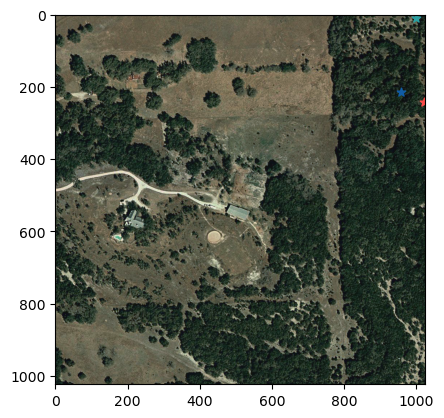

In [63]:
plt.imshow(img_A.squeeze().permute(1, 2, 0))
ax = plt.gca()
prompts = points_coords.squeeze()
colors = [
    np.random.choice(range(256), size=3) / 255
    for _ in range(len(prompts))
]
for pt, c in zip(prompts, colors):
    ax.scatter(*pt, color=c, marker="*", s=40)

In [97]:
batch_ = {
    "img_A":img_A,
    "img_B":img_B,
    "point_coords":point_coords,
    "label":label
}

dispatcher = ManyToManyAugmentationDispather(
    AugmentationSequential(
        K.augmentation.ColorJiggle(brightness=0.2, contrast=0.2, saturation=0.4, hue=0.1, p=1.0), # , same_on_batch=False
        K.augmentation.RandomAffine(degrees=30, translate=(0.1, 0.1), scale=(0.8, 1.2), p=1.0),
        K.augmentation.RandomHorizontalFlip(p=1.0),
        data_keys=["input", "input", "keypoints", "mask"]
    )
)

output = dispatcher(batch_.values())
n_batch = dict(zip(list(batch_), next(iter((output)))))

new_batch = batch | n_batch

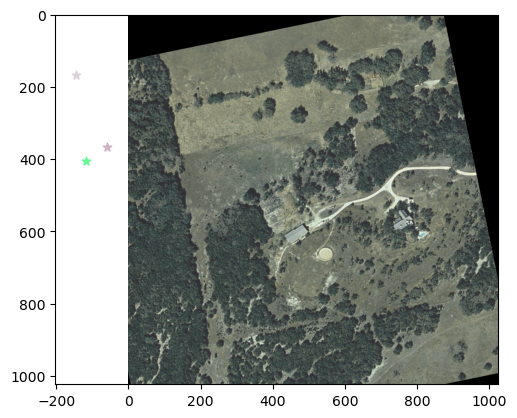

In [98]:
plt.imshow(invert(new_batch["img_A"][0]))
ax = plt.gca()
prompts = output[0][2].squeeze()
colors = [
    np.random.choice(range(256), size=3) / 255
    for _ in range(len(prompts))
]
for pt, c in zip(prompts, colors):
    ax.scatter(*pt, color=c, marker="*", s=40)

In [13]:
# input_1, input_2 = torch.randn(2, 3, 5, 6), torch.randn(2, 3, 5, 6)
# mask_1, mask_2 = torch.ones(2, 3, 5, 6), torch.ones(2, 3, 5, 6)
aug_list = ManyToManyAugmentationDispather(
    AugmentationSequential(
        K.augmentation.ColorJiggle(0.1, 0.1, 0.1, 0.1, p=1.0),
        K.augmentation.RandomAffine(360, p=1.0),
        data_keys=["img_A", "label",],
    ),
    AugmentationSequential(
        K.augmentation.ColorJiggle(0.1, 0.1, 0.1, 0.1, p=1.0),
        K.augmentation.RandomAffine(360, p=1.0),
        data_keys=["input", "mask",],
    )
)
output = aug_list((input_1, mask_1), (input_2, mask_2))

In [16]:
len(output)

2

In [18]:
len(output[0])

2

In [16]:
t1 = torch.zeros(1, 256, 64, 64)
t2 = torch.ones(1, 256, 64, 64)

In [17]:
t = torch.cat([t1, t2], axis=1)

In [59]:
t = torch.stack([t1, t2], axis=2)

In [60]:
t.shape

torch.Size([1, 256, 2, 64, 64])

In [61]:
t_f = t.view(1, 256, 2,  -1)

In [62]:
t_f.shape

torch.Size([1, 256, 2, 4096])

In [63]:
t_f = t_f.flatten(2,3)

In [64]:
t_f.shape

torch.Size([1, 256, 8192])

In [65]:
t_f[:, :, 4096:].shape

torch.Size([1, 256, 4096])

In [67]:
t_f[:, :, :4096]

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])

In [66]:
t_f[:, :, 4096:]

tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])

In [68]:
t_a = t_f.view(1, 256, 2, 64, 64)

In [80]:
t.view(1, 256, -1)[:, :, :4096].sum()

tensor(0.)

In [72]:
t_a[:, :, 1, :, :]

tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         ...,

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 

In [40]:
t_f.view(1, 256, -1)[:, :, :2000]

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])

In [26]:
t1_b = t_f[:, :, :4096]

In [29]:
t1_b.shape

torch.Size([1, 256, 4096])

In [24]:
t2_b = t_f[:, : 4096:]

In [32]:
t2_b[0]

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]])

In [81]:
attn = torch.rand((2, 8, 8281, 8281))
rpeq = torch.rand((2, 8, 8281, 1))
rpeq2 = torch.rand((2, 8, 8281, 16560))

In [82]:
rpeq2.shape

torch.Size([2, 8, 8281, 16560])

In [83]:
res = torch.cat([rpeq, rpeq2], axis=-1)

In [85]:
res.shape

torch.Size([2, 8, 8281, 16561])

In [86]:
attn.shape

torch.Size([2, 8, 8281, 8281])

In [84]:
res = res + attn

RuntimeError: The size of tensor a (16561) must match the size of tensor b (8281) at non-singleton dimension 3

In [87]:
res = attn + rpeq

In [88]:
res.shape

torch.Size([2, 8, 8281, 8281])